In [69]:
# Import Libraries

using DataFrames, CSV, Statistics, Plots, JSON3, ArchGDAL

# Shelter Data

In [70]:
# Load data

df = select(CSV.read("shelters.csv", DataFrame; missingstring=["NA","NaN","N/A"]),
            r"^(CS_ID|Division|District|Upazila|Union|lon|lat|Shelter Name \(English\)|DRRO Capacity)$")
df = first(df, 163)
first(df, 1)

Row,CS_ID,Division,District,Upazila,Union,lon,lat,Shelter Name (English),DRRO Capacity
,String7,String15,String15,String7,String31,String15,String15,String,String7
1,CS_1,Chittagong,Cox'S Bazar,Teknaf,Teknaf Paurashava,92.29067798,20.85692678,Baitus Saraf muhammodia Riadul Jannah Dakil Madrasha,1000


In [71]:
# Fill missing values

col = Symbol("DRRO Capacity")

clean_number(x) = try
    # convert String7 → String
    s = String(x)

    # normalize (remove commas, trim spaces)
    s = replace(strip(s), "," => "")

    # treat empty or bad text as missing
    if isempty(s) || s in ["NA","N/A","na",".", "-", "--"]
        return missing
    end

    return parse(Float64, s)
catch
    missing
end

# 1. Convert entire column to Float64 or missing
df[!, col] = clean_number.(df[!, col])

# 2. Compute max
max_cap = maximum(skipmissing(df[!, col]))

# 3. Fill missing with max
df[!, col] = coalesce.(df[!, col], max_cap)

cols = [:lon, :lat]

for c in cols
    df[!, c] = passmissing(x -> parse(Float64, String(x))).(df[!, c])
end

In [72]:
# Normalize the union column to lowercase
df.Union = lowercase.(String.(df.Union))

# no islands
island_unions = ["st. martin dwip", "st. martin's"]
df = filter(:Union => u -> !(u in island_unions), df)

unique(df.Union)


12-element Vector{String}:
 "teknaf paurashava"
 "sabrang"
 "palong khali"
 "ratna palong"
 "nhilla"
 "raja palong"
 "baharchhara"
 "whykong"
 "haldia palong"
 "jalia palong"
 "teknaf sadar"
 "teknaf"

# Grid

In [73]:
# make the grid

lat = df_merged.lat
lon = df_merged.lon

# Compute bounding box of Cox's Bazar shelters
lat_min = minimum(skipmissing(lat))
lat_max = maximum(skipmissing(lat))

lon_min = minimum(skipmissing(lon))
lon_max = maximum(skipmissing(lon))

# Add ~10 km padding in all directions
km = 1
deg1km_lat = 0.008993               # km to degrees latitude
deg1km_lon = 0.008993 * cosd(21)    # degrees longitude at Cox's Bazar latitude

lat_pad = 10 * deg1km_lat
lon_pad = 10 * deg1km_lon

lat_min -= lat_pad
lat_max += lat_pad
lon_min -= lon_pad
lon_max += lon_pad

# Generate grid steps (1 km)
lat_step = deg1km_lat
lon_step = deg1km_lon

lat_bins = collect(lat_min:lat_step:lat_max)
lon_bins = collect(lon_min:lon_step:lon_max)

# Convert bins to centers
lat_centers = lat_bins .+ lat_step/2
lon_centers = lon_bins .+ lon_step/2

# Create full grid (Cartesian product)
grid = DataFrame(
    lat_center = repeat(lat_centers, inner=length(lon_centers)),
    lon_center = repeat(lon_centers, outer=length(lat_centers))
)

# Add grid IDs
grid.lat_bin = repeat(1:length(lat_centers), inner=length(lon_centers))
grid.lon_bin = repeat(1:length(lon_centers), outer=length(lat_centers))
grid.grid_id = string.(grid.lat_bin, "_", grid.lon_bin)

first(grid, 5)

Row,lat_center,lon_center,lat_bin,lon_bin,grid_id
,Float64,Float64,Int64,Int64,String
1,20.6752,91.9692,1,1,1_1
2,20.6752,91.9776,1,2,1_2
3,20.6752,91.986,1,3,1_3
4,20.6752,91.9944,1,4,1_4
5,20.6752,92.0028,1,5,1_5


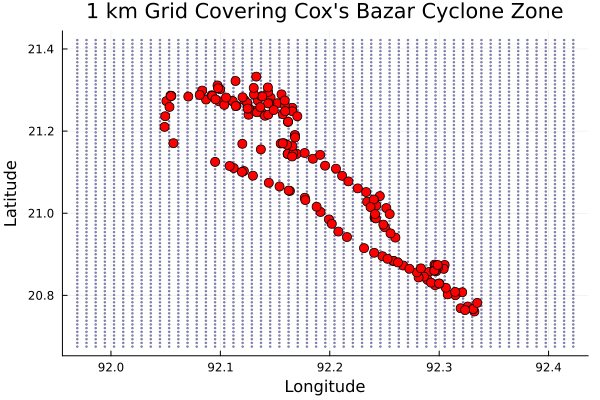

In [74]:
# plot the grid and shelters

scatter(
    grid.lon_center, grid.lat_center,
    markersize = 1, alpha = 0.4, legend = false,
    title = "1 km Grid Covering Cox's Bazar Cyclone Zone",
    xlabel = "Longitude", ylabel = "Latitude",
    color = :blue, label = "Grid cells"
)

scatter!(
    df.lon, df.lat,
    markersize = 5, color = :red, label = "Shelters"
)


In [75]:
CSV.write("grid.csv", grid)
CSV.write("shelter_data.csv", df_merged)

"shelter_data.csv"